# Dense core collapse with RAMSES

This document is aimed as a tutorial to explore the physics of the protostellar collapse using the RAMSES code. If you have never used RAMSES, you can take a look at the quick start guide. Otherwise you can proceed directly with this tutorial

Star formation is a complex problem which invokes a huge range of scales, physical processes (MHD, radiation, self-gravity etc.) and components (gas, dust, photons etc.). In this project, we are going to investigate a particular problem of star formation, which is the gravitational collapse of dense cores (or prestellar cores) which occurs when they reach their Jeans mass. This process is at the origin of star formation and also, around the star and through angular momentum conservation, protostellar disk formation. 


## Collapse setup

As often when studying the ISM, the question of initial conditions is tricky. In the collapse case we should, in principle start from very large scales (arguably galactic scales) and zoom-in up to dense core scales. While some groups are investigating this problem, this is of course not possible for a practical session. Therefore we are going to use a much simple set of initial conditions : the Boss and Bodenheimer setup. 

In this setup, we consider an isolated spherical dense core of mass M, radius R and temperature T. Generally, we fix the mass and temperature and compute the radius to ensure that the cloud is gravitationally collapsing. Often, we fix the radius using the thermal-to-gravitational energy ratio $\alpha$ (or Virial parameter).

$\alpha = \frac{5}{2} \frac{R}{GM} \frac{k_B T}{\mu_g m_H}$

where $G$ and $k_B$ are the gravitational and Boltzmann constants and $\mu_g=2.31$ is the mean molecular weight. With the RAMSES setup, we go for a simpler option. Where R is one fourth of the lenght of the box size.


You can also add some solid body rotation $\Omega$, assuming a certain value for rotational-to-gravitational energy ratio $\beta$. To initialize $\Omega$, we $\beta$ such as 


$\beta =\frac{R^3 \Omega^2}{3 \mathcal{G} M_{\odot} }$


Typically, we set it to a few percent, which is in lines with observations of prestellar cores.


### Equation of state 

The radiative transfer during the collapse is, in principle, a quite complex business and requires to use a RT solver which is able to treat properly infrared radiation. We often circumvent the issue by assuming a EOS as follows

$P = \rho c_{s,0}^2 \left[1 + \left(\frac{\rho}{\rho_{\mathrm{ad}}}\right)^{\gamma-1}\right]$


This equation allows to recover the two regimes of the first collapse, namely the isothermal phase at low density when radiation can escape freely from the core in the IR and the adiabatic contraction of the first Larson core at high density ($\rho>\rho_{\mathrm{ad}}$). 

## Parameter file (the namelist)

Here is a summary of the most important parameters that are relevant for collapse calculations. You have to set them in your nml file prior running the simulation.

1. `RUN_PARAMS`. This section defines some of the most basic properties of the run, and the importnat ones for us here are the following:
```
hydro=.true.    ! We solve the hydro equations 
poisson=.true.  ! We solve the Poisson equation
nrestart=0      ! This not a restart. Set to i (the output i) to restart
nremap=10       ! We do the load balancing every 10 dt. This should be reduced for big runs.
nsubcycle=6*1,2 ! We do sub cycling but not for the 6 first level of refinement (starting from lmin)
```

2. `AMR_PARAMS`. This defines the global mesh properties and memory footprint of the code with the following parameters:
```
levelmin=5          ! this is the lowest level (same that in the initial conditions).
levelmax=15         ! This is the maximum level of refinement level allowed. 
ngridmax=1000000    ! This is the maximum number of grids (oct) that we allow
nexpand=2           ! is the smoothing of the grid at the boundary between levels
boxlen=4.0          ! This is the box size (the core radius is set to 1 in code unit)
```

3. `BOUNDARY_PARAMS` tells RAMSES what boundary conditions to use. Here this is zero gradients 
```
nboundary = 6
bound_type= 2, 2, 2, 2, 2, 2
ibound_min=-1,+1,-1,-1,-1,-1
ibound_max=-1,+1,+1,+1,+1,+1
jbound_min= 0, 0,-1,+1,-1,-1
jbound_max= 0, 0,-1,+1,+1,+1
kbound_min= 0, 0, 0, 0,-1,+1
kbound_max= 0, 0, 0, 0,-1,+1
```


4. `INIT_PARAMS` tells RAMSES about the initial conditions we want to set.

```
alpha_dense_core=0.35 ! NOT USED in this setup
beta_dense_core=0.0   ! Set the amount of rotation
crit_dense_core=0.0   ! Sets the inverse mass-to-flux ratio (the criticality of the core)
delta_rho=0.0         ! Sets the amplitude of the density perturbation
```


5. `OUTPUT_PARAMS` defines the output strategy. Here we make a snapshot evrery 50 dt and also dump the ouptuts of the tout array
```
foutput=50 
noutput=7
tout=0,0.2714,0.5428,0.691262,0.8142,1.0857,2.
```

6. `POISSON_PARAMS` defines the parameters for gravity

```
gravity_type=0 ! We solve self-gravity
epsilon=1d-4   ! Tolerance for the error on the gravitational potential
```

7. `HYDRO_PARAMS` defines the parameters for the hydrodynamics

```
gamma=1.66666667    ! Adiabatic index
courant_factor=0.8  ! Safety factor for the courant conditions, sets the timestep (>1 is unstable)
slope_type=1        ! Slope limiter for the predictor corrector. 1= minmod
scheme='muscl'      ! Scheme to solve the hydro
riemann='llf'       ! Riemann solver. Good options are llf, hll, hllc.
```

8. `PHYSICS_PARAMS` defines the parameters related with the EOS here.

```
n_star=1d-13
T2_star=4.55
g_star=0.6666667
```

9. `REFINE_PARAMS` defines the refinement strategy. Here we implement a Jeans-length based refinement, were any cell with more than 20 points per Jeans length for 10 successive levels
```
jeans_refine=20*10.
interpol_var=1   
interpol_type=0
```


We provided a `barotrop.nml` in the `namelists/` folder which will be the basis for this tutorial.



## A quick first collapse model : exploration of the first Larson core 

Let's now run a first collapse calculation with the aim of writing a python pipeline to analyse it. The goal of this exercise is to write a scripts that analyses every output of the simulations. For each snapshot we will compute


1. a slice of the density and temperature in the x, y and z directions


2. a density PDF to learn how to handle the raw data that are read by OSYRIS.


To perform this analysis we will use the documentation of Osyris (available at https://osyris.readthedocs.io/en/stable/).


To run our calculation we are going to need to use the coeur patch.  It is located at 

```
../patch/mhd/coeur
```

Note that there is also a version of this patch in the hydro folder but we are going to compile the code with the MHD solver (and eventually set B=0 when we want to run hydro simulations). To compile with the coeur patch go back to the bin folder, clean it with the command
```
make clean
```

And now we compile it like that 


```
make NDIM=3 PATCH=../patch/mhd/coeur SOLVER=mhd NDIM=3
```
You have now a ramses3d executable that can be used to run collapse calculations (using the correct namelist).


Now we would like to use ramses mpi parallelisation in order to run it faster. We therefore need to compile the code with the following command (and openmpi installed on your machine)

```
 make clean
 make NDIM=3 PATCH=../patch/mhd/coeur SOLVER=mhd NDIM=3 MPI=1
```


Now copy the executable and the namelist file into  collapse-run directory when you want to run the simulation. Once it's done you can go in this directory. Let's assume you want to run the code with 4 CPUs, then the command is simply 

```
mpirun -np 4 ramses3d barotrop.nml
```


Note that you can keep the terminal information in a log file (e.g. collapse.log) with the command 


```
mpirun -np 4 ramses3d barotrop.nml > collapse.log
```

Processing 1 files in ../../../RUNS/RUN1/output_00006
Loaded: 106688 cells, 0 particles.


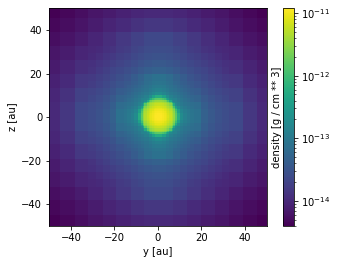

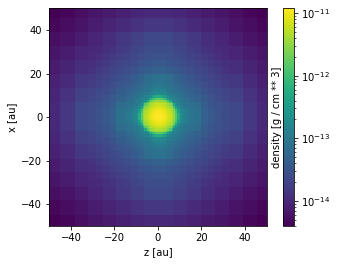

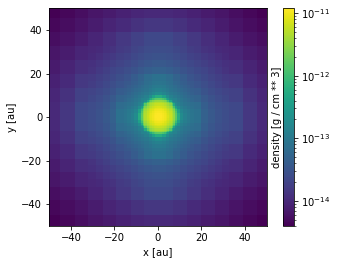

In [16]:
import osyris
import numpy as np
au = osyris.units("au")
data = osyris.Dataset(6, path='../../../RUNS/RUN1/').load() # Change this path to the path of the model
# We find the center according to the density
ind = np.argmax(data["hydro"]["density"])
center = data["amr"]["position"][ind]
osyris.map(
    data["hydro"]["density"], norm="log", dx=100 * au, origin=center, direction="x"
)
osyris.map(
    data["hydro"]["density"], norm="log", dx=100 * au, origin=center, direction="y"
)
osyris.map(
    data["hydro"]["density"], norm="log", dx=100 * au, origin=center, direction="z"
)

Figure 1 Exemples of 100 au x 100 au slices in the x,y and z directions of a collapse without rotation obtained with OSYRIS. As can be seen, without rotation the first Larson core remains mostly spherical.

### More fun 

<span style="color:red"> Before you do this analysis, you should start the next simulations which take a longer time to complete.</span> 


We can now start to extract structures (such as the first core) to analyse the model. When the density reaches values higher than $10^{-11}~$g cm$^{-3}$, fragments called first Larson cores are forming. We propose to measure the mass as a function of time. This will require to filter the data with masks (using the criterion $\rho>10^{-11}~$g cm$^{-3}$) and to perform the mass measurement on these filtered data.
You can try to play with the initial cloud mass to see if it impacts or not the mass of the First larson core.



## Adding rotation 

Let's now add rotation to the previous setup. The solid body rotation rate is controlled with the beta\_dense\_core parameter. Typically, you can choose a value between 0.01 and 0.05 to stay in the observed range of dense core (the image of the tutorial is done with 0.05). You should also set delta\_rho to 0.1. This sets a m=2 density perturbation of 10\% amplitude which prevent the formation of a spurious m=4 mode which could unfortunately form as a consequence of the cartesian grid. 

 

 Lets now play with this parameter and see its impact on the fragmentation and disk formation during the collapse. For that, we need to push a bit the calculation, as fragmentation will not happen immediately. We will need to run the simulation at least up to output 16 (more ore less a few depending on your choice of initial conditions). If time is limited, we can distribute some outputs to analyse them once you have run the first timesteps yourself. 


Processing 1 files in ../../../RUNS/RUN2/output_00016
Loaded: 273792 cells, 0 particles.


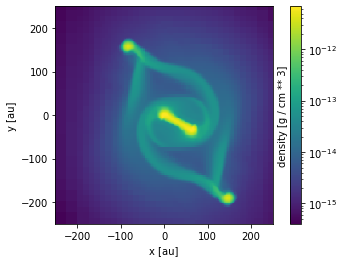

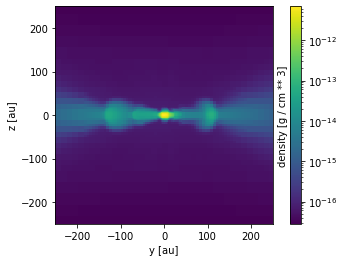

In [42]:
import osyris
import numpy as np
au = osyris.units("au")
data = osyris.Dataset(16, path='../../../RUNS/RUN2/').load() # Change this path to the path of the model
# We find the center according to the density
ind = np.argmax(data["hydro"]["density"])
center = data["amr"]["position"][ind]
osyris.map(
    data["hydro"]["density"], norm="log", dx=500 * au, origin=center, direction="z"
)

osyris.map(
    data["hydro"]["density"], norm="log", dx=500 * au, origin=center, direction="x"
)

Figure 2 Slice of 500 au x 500 au in the z and y direction obtained with OSYRIS for the snapshot 16 centered at the position of the density maximum. 

Wth the z-slice, we clearly see that the core has fragmented into several objects. With the x-slice, it also becomes clear that matter is organised in a thin disk-like rotationally supported structure which is the consequence of angular momentum conservation. 

### More fun 

We can count the fragment, look at their separation as a function of time and their mass distribution as a function of the rotation rate, the density perturbation.
It is also interesting to look at the disk properties, when a disk is formed. For that we need to have some seletion criterion for the disk. Typically, we consider that a disk is a dense and rotationally supported structure. To extract it, we can use the following criterion. The disk material must be 

1. Dense enough.


2. Supported by rotation


3.  Not thermally supported (this is the first core).


Once you have extracted the disk, try to measure its size and mass as a function of the time. You can also play with the extraction parameters.

Processing 1 files in ../../../RUNS/RUN2/output_00016
Loaded: 273792 cells, 0 particles.


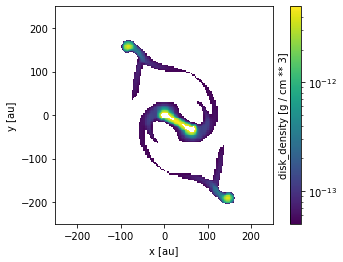

In [67]:
import osyris
import numpy as np
au = osyris.units("au")
data = osyris.Dataset(16, path='../../../RUNS/RUN2/').load() # Change this path to the path of the model
# We find the center according to the density
ind = np.argmax(data["hydro"]["density"])
center = data["amr"]["position"][ind]
condition = (data["hydro"]["density"] < (5.0e-14 * osyris.units("g/cm**3"))) | (
    data["hydro"]["density"] > (5.0e-12 * osyris.units("g/cm**3"))
)
data["hydro"]["disk_density"] = osyris.Array(
    np.ma.masked_where(condition.values, data["hydro"]["density"].values),
    unit=data["hydro"]["density"].unit,
)
osyris.map(data["hydro"]["disk_density"], dx=500 * au, norm="log", origin=center)

Figure 3 Same as before, but we selected the disk material.

## Magnetic fields

Dense core are actually magnetised, and the magnetic field, although likely sub-critical is likely to be dynamically relevant. Usually, we set the magnetic field strength according to the mass-to-flux ratio $\mu$ (in units of critical mass-to-flux ratio). When $\mu>1$, the collapse can happen, typically $1<\mu<10$ in dense cores, so lets explore here this range. By setting the parameter crit_dense_core in the namelist, we are setting $\frac{1}{\mu}$. We can start to run a simulation with crit_dense_core=0.3, starting from the previous setup. For this value the magnetic field is important while not strong enough to stop the collapse.


Lets look again at the collapse seen face-one (z slice). Normally, you should see that for mass-to-flux ratio of the order of a few, the disk is gone. We can observe a dense thin structure around the first core but this is not a disk, this is a pseudo-disk. The pseudo-disk is a consequence of the pinching of the magnetic field line that compress the matter in the equatorial plane but it is not a supported structure (it is collapsing). 




Processing 1 files in ../../../RUNS/RUN3/output_00013
Loaded: 144208 cells, 0 particles.


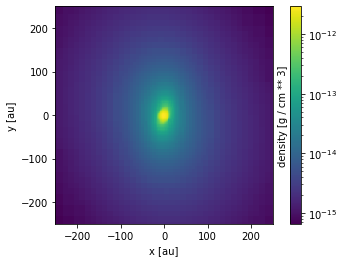

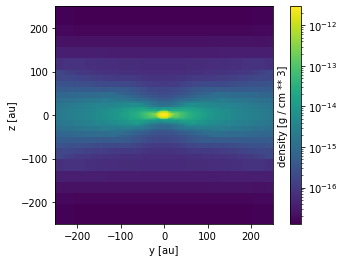

In [51]:
import osyris
import numpy as np
au = osyris.units("au")
data = osyris.Dataset(13, path='../../../RUNS/RUN3/').load() # Change this path to the path of the model
# We find the center according to the density
ind = np.argmax(data["hydro"]["density"])
center = data["amr"]["position"][ind]
osyris.map(
    data["hydro"]["density"], norm="log", dx=500 * au, origin=center, direction="z"
)

osyris.map(
    data["hydro"]["density"], norm="log", dx=500 * au, origin=center, direction="x"
)

Figure 4 Slice of 500 au x 500 au in the x direction obtained with OSYRIS that shows the pseudo-disk for a collapse model with crit_dense_core=0.3.


Why is the disk gone ? During the collapse, the twisting of the magnetic field lines generates an intense magnetic braking which suppresses rotation. This so-called magnetic braking catastrophe is a classic problem in the disk formation community. You can take a look at the magnetic field lines to see both the pinching and twisting on the field. 



This problem is now solved for the most part by including non-ideal MHD processes that decouple the gas from the magnetic field but are unfortunately not yet implemented in the public version of ramses. Two other potential solutions to recover the disks have also been brought-up by the community : a misalignment between the magnetic field and the rotation axis and turbulence. 

Quite interestingly, magnetised models also produce protostellar outflows, you will see them well if you integrate the model up to output 22. This is good since these outflows are observed. You can look at them with edge-one slices and try to see how they depend on the initial magnetic field strength.

Processing 1 files in ../../../RUNS/RUN3/output_00022
Loaded: 164536 cells, 0 particles.


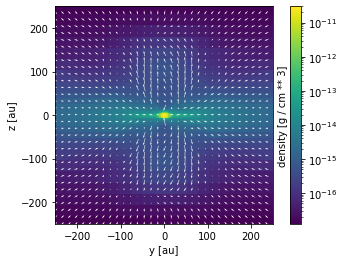

In [66]:
import osyris
import numpy as np
au = osyris.units("au")
data = osyris.Dataset(22, path='../../../RUNS/RUN3/').load() # Change this path to the path of the model
# We find the center according to the density
ind = np.argmax(data["hydro"]["density"])
center = data["amr"]["position"][ind]

osyris.map(
        {"data": data["hydro"]["density"], "norm": "log"}, 
    {"data": data["hydro"]["velocity"], "mode": "vec"} , norm="log", dx=500 * au, origin=center, direction="x"
)


Figure 5 Slice of 500 au x 500 au in the x direction obtained with OSYRIS that shows a MHD outflow for a collapse model with crit=0.3 as it propagates in the z direction.

## Misaligned magnetic fields

Let us now pay attention to the case when the axis of rotation and of the magnetic field are misaligned. This is not implemented in the coeur setup of RAMSES, so you will need to copy the patch coeur_misaligned in the patch/mhd folder of ramses and recompile the code with the commands 

```
make clean
```

```
make NDIM=3 PATCH=../patch/mhd/coeur_misaligned SOLVER=mhd NDIM=3
```

Now, lets recover the namelist from the previous run and add an angle with the new parameter theta_mag in the init_params, we can start with a value of 60 (degrees). 

Lets look at the result early on (output 10) at a relatively large scale. We can see that the flow is tilted with respect to the the z axis because the rotation axis is not z anymore but is tilted by the angle theta_mag.

Processing 1 files in ../../../RUNS/RUN4/output_00007
Loaded: 74166 cells, 0 particles.


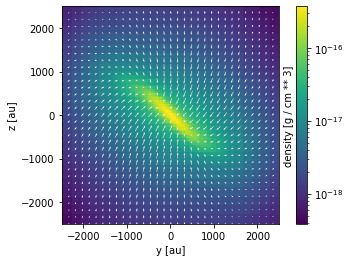

In [132]:
import osyris
import numpy as np
au = osyris.units("au")
data = osyris.Dataset(7, path='../../../RUNS/RUN4/').load() # Change this path to the path of the model
# We find the center according to the density
ind = np.argmax(data["hydro"]["density"])
center = data["amr"]["position"][ind]

osyris.map(
        {"data": data["hydro"]["density"], "norm": "log"}, 
    {"data": data["hydro"]["velocity"], "mode": "vec"} , norm="log", dx=5000 * au, origin=center, direction='x'
)


Figure 6 Slice of 5000 au x 5000 au in the x direction obtained with OSYRIS that shows that the axis of rotation is now tilted by 60 degrees

We can redo the same figure, but making it perpendicular to the new rotation axis thanks to the functionality of osyris which can find the angular momentum axis.

Processing 1 files in ../../../RUNS/RUN4/output_00007
Loaded: 74166 cells, 0 particles.
Basis vectors:
'normal' Value: -2.219e+53, 4.048e+51, -1.985e+53 [cm ** 2 * g / s] (), {x,y,z}
'pos_u' Value: 1.0, 1.0, -1.097 [cm ** 2 * g / s] (), {x,y,z}
'pos_v' Value: 1.941e+53, -4.421e+53, -2.260e+53 [cm ** 4 * g ** 2 / s ** 2] (), {x,y,z}


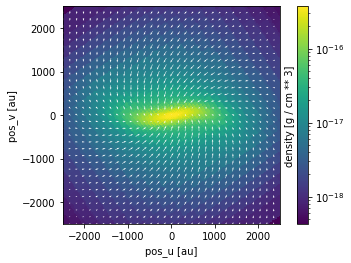

In [131]:
import osyris
import numpy as np
au = osyris.units("au")
data = osyris.Dataset(7, path='../../../RUNS/RUN4/').load() # Change this path to the path of the model
# We find the center according to the density
ind = np.argmax(data["hydro"]["density"])
center = data["amr"]["position"][ind]

osyris.map(
        {"data": data["hydro"]["density"], "norm": "log"}, 
    {"data": data["hydro"]["velocity"], "mode": "vec"} , norm="log", dx=5000 * au, origin=center, direction='top'
)

Figure 6 Same as before, but face-on.

If we now wait a bit longer, and make a 'top' slice i.e. a slice in the rotation plane we can see that we now have a disk. We can play the same game as before (measuring its properties) and also test the disk properties as a function of the angle between the magnetic field and rotation. 
An intersting question might be : which is the limit angle to form a disk for a given magnetic field strenght ?

Processing 1 files in ../../../RUNS/RUN4/output_00018
Loaded: 172033 cells, 0 particles.
Basis vectors:
'normal' Value: -2.234e+50, -1.299e+50, -5.748e+50 [cm ** 2 * g / s] (), {x,y,z}
'pos_u' Value: 1.0, 1.0, -0.615 [cm ** 2 * g / s] (), {x,y,z}
'pos_v' Value: 6.547e+50, -7.122e+50, -9.349e+49 [cm ** 4 * g ** 2 / s ** 2] (), {x,y,z}


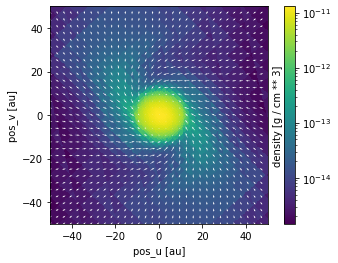

In [150]:
import osyris
import numpy as np
au = osyris.units("au")
data = osyris.Dataset(18, path='../../../RUNS/RUN4/').load() # Change this path to the path of the model
# We find the center according to the density
ind = np.argmax(data["hydro"]["density"])
center = data["amr"]["position"][ind]

osyris.map(
        {"data": data["hydro"]["density"], "norm": "log"}, 
    {"data": data["hydro"]["velocity"], "mode": "vec"} , norm="log", dx=100 * au, origin=center, direction='top'
)

Figure 7 Slice of 500 au x 500 au in the mid-plane which shows that we can recover a disk when accounting for a misalignment between the magnetic field and rotation.

Processing 1 files in ../../../RUNS/RUN4/output_00018
Loaded: 172033 cells, 0 particles.
Basis vectors:
'normal' Value: -2.234e+50, -1.299e+50, -5.748e+50 [cm ** 2 * g / s] (), {x,y,z}
'pos_u' Value: 1.0, 1.0, -0.615 [cm ** 2 * g / s] (), {x,y,z}
'pos_v' Value: 6.547e+50, -7.122e+50, -9.349e+49 [cm ** 4 * g ** 2 / s ** 2] (), {x,y,z}


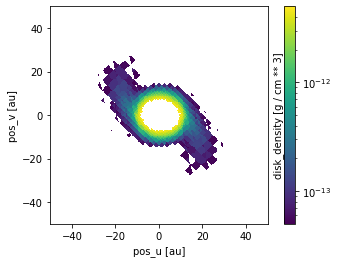

In [153]:
import osyris
import numpy as np
au = osyris.units("au")
data = osyris.Dataset(18, path='../../../RUNS/RUN4/').load() # Change this path to the path of the model
# We find the center according to the density
ind = np.argmax(data["hydro"]["density"])
center = data["amr"]["position"][ind]
condition = (data["hydro"]["density"] < (5.0e-14 * osyris.units("g/cm**3"))) | (
    data["hydro"]["density"] > (5.0e-12 * osyris.units("g/cm**3"))
)
data["hydro"]["disk_density"] = osyris.Array(
    np.ma.masked_where(condition.values, data["hydro"]["density"].values),
    unit=data["hydro"]["density"].unit,
)
osyris.map(data["hydro"]["disk_density"], dx=100 * au, norm="log", origin=center, direction='top')

## A non exhaustive list of collapse papers with RAMSES

If you want to dig deeper in the collapses with RAMSES, here is a list of the some of (but not all) the papers that where written using this setup (generally with a modified version including more physics)


1. Hennebelle and Fromang 2008 : Magnetic processes in a collapsing dense core I.

2. Hennebelle and Teyssier 2008 : Magnetic processes in a collapsing dense core II.

3. Commerçon et al. 2010 : Protostellar collapse: radiative and magnetic feedbacks on small-scale fragmentation

4. González et al. 2015 : Multigroup radiation hydrodynamics with flux-limited diffusion and adaptive mesh refinement


<font color='red'> WORK IN PROGRESS</font>
